In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
##===
# Select state we want to predict
# New York , California , Florida , Texas
STATE = 'California'

WEIGHTDECAY = 0
TRAIN = True
seq_length = 21
N_EPOCHS = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
##===

#### Model Config ===
# channel_config = np.array([[1,64,128],[128,64,64],[64,32,1]])
#channel_config = np.array([[1,7,14],[14,7,7],[7,4,1]])
channel_config = np.array([[1,7,14],[14,21,14],[14,7,1]])

## Data frame Format

### Import Data from CSV file

In [4]:
#df = pd.read_excel("./drive/Shareddrives/BI&A/Data/Cleaned Data.xlsx")
df = pd.read_csv('Cleaned_data.csv')

In [5]:
df.head()

,date,state,fips,cases,daily_cases,deaths,daily_deaths,total_vaccinations,total_distributed,daily_distributed,total_people_vaccinated,daily_people_vaccinated,total_people_fully_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
0,3/13/2021,Alabama,1,503305,594,10327,28,1288242,1918560.0,80160.0,841394.0,24976.0,492755.0,20430.0,"26,935",-1.013041
1,3/12/2021,Alabama,1,502711,448,10299,25,1249205,1838400.0,22170.0,816418.0,25554.0,472325.0,19579.0,"26,375",-1.013041
2,3/11/2021,Alabama,1,502263,865,10274,52,1209802,1816230.0,40570.0,790864.0,22362.0,452746.0,17728.0,"25,376",-1.013041
3,3/10/2021,Alabama,1,501398,782,10222,36,1173820,1775660.0,86610.0,768502.0,21234.0,435018.0,14935.0,"24,827",-1.013041
4,3/9/2021,Alabama,1,500616,524,10186,38,1140984,1689050.0,60700.0,747268.0,14301.0,420083.0,10146.0,"24,118",-1.013041


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20618 entries, 0 to 20617
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           20618 non-null  object 
 1   state                          20618 non-null  object 
 2   fips                           20618 non-null  int64  
 3   cases                          20618 non-null  int64  
 4   daily_cases                    20618 non-null  int64  
 5   deaths                         20618 non-null  int64  
 6   daily_deaths                   20618 non-null  int64  
 7   total_vaccinations             3801 non-null   object 
 8   total_distributed              3801 non-null   float64
 9   daily_distributed              3801 non-null   float64
 10  total_people_vaccinated        3801 non-null   float64
 11  daily_people_vaccinated        3801 non-null   float64
 12  total_people_fully_vaccinated  3801 non-null  

In [7]:
df = df.drop(labels=['cases', 'deaths', 'total_vaccinations', 'total_distributed', 'total_people_vaccinated', 'total_people_fully_vaccinated'], axis=1)
df.head()

,date,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
0,3/13/2021,Alabama,1,594,28,80160.0,24976.0,20430.0,"26,935",-1.013041
1,3/12/2021,Alabama,1,448,25,22170.0,25554.0,19579.0,"26,375",-1.013041
2,3/11/2021,Alabama,1,865,52,40570.0,22362.0,17728.0,"25,376",-1.013041
3,3/10/2021,Alabama,1,782,36,86610.0,21234.0,14935.0,"24,827",-1.013041
4,3/9/2021,Alabama,1,524,38,60700.0,14301.0,10146.0,"24,118",-1.013041


In [8]:
df['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [9]:
# Set date to be datetime format and sort by date and fips
df['date'] = pd.to_datetime(df.date)
df = df.sort_values(by=['date', 'fips'], axis=0, ascending=True)
df

,date,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
19484,2020-01-21,Washington,53,1,0,NaN,NaN,NaN,NaN,NaN
19483,2020-01-22,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
19482,2020-01-23,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
5684,2020-01-24,Illinois,17,1,0,NaN,NaN,NaN,NaN,NaN
19481,2020-01-24,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20250,2021-03-13,Wyoming,56,0,0,0.0,4086.0,2945.0,"4,085",0.000000
4168,2021-03-13,Guam,66,1,0,0.0,226.0,1440.0,"1,272",-5.361115
13475,2021-03-13,Northern Mariana Islands,69,1,0,0.0,230.0,163.0,246,NaN
15319,2021-03-13,Puerto Rico,72,235,0,19550.0,32455.0,20400.0,"19,615",0.000000


In [10]:
df_clean = df[df.state == STATE]
df_clean = df_clean.set_index('date')
df_clean

,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
date,,,,,,,,,
2020-01-25,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-26,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-27,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-28,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-29,California,6,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-03-09,California,6,4131,243,1162100.0,82138.0,37820.0,"204,065",-32.197826
2021-03-10,California,6,3464,257,254140.0,96767.0,40388.0,"190,191",-32.197826
2021-03-11,California,6,3560,255,424380.0,103215.0,56316.0,"194,328",-32.197826


In [11]:
rmlabels=['state', 'fips', 'daily_deaths', 'daily_distributed','daily_people_vaccinated', 'daily_people_fully_vaccinated',
          'daily_vaccinations', 'mobility_composite']
df_clean = df_clean.drop(labels=rmlabels, axis=1)
df_clean = df_clean.iloc[df_clean.shape[0]-378:]
df_clean.shape

(378, 1)

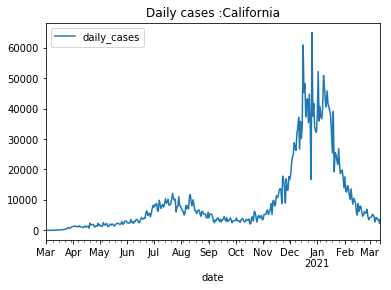

In [12]:
df_clean.plot(title=f"Daily cases :{STATE}")

In [13]:
df.head()

,date,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
19484,2020-01-21,Washington,53,1,0,NaN,NaN,NaN,NaN,NaN
19483,2020-01-22,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
19482,2020-01-23,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN
5684,2020-01-24,Illinois,17,1,0,NaN,NaN,NaN,NaN,NaN
19481,2020-01-24,Washington,53,0,0,NaN,NaN,NaN,NaN,NaN


In [14]:
df_state = df[df.state == STATE]

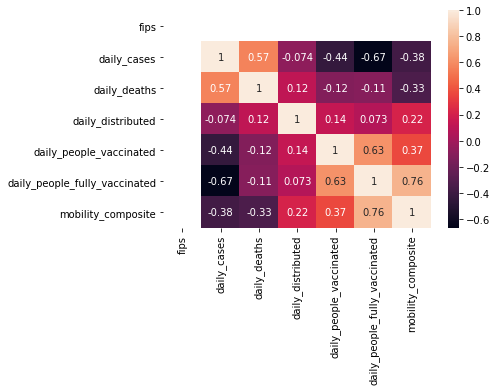

In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df_state.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### select the high correlation to be our factors

- daily death
- daily people vacinated 
- daily_distibuted  
- daily case 

In [16]:
df_state.columns

Index(['date', 'state', 'fips', 'daily_cases', 'daily_deaths',
       'daily_distributed', 'daily_people_vaccinated',
       'daily_people_fully_vaccinated', 'daily_vaccinations',
       'mobility_composite'],
      dtype='object')

In [17]:
df_state = df_state.set_index('date') 

In [18]:
df_state.head()

,state,fips,daily_cases,daily_deaths,daily_distributed,daily_people_vaccinated,daily_people_fully_vaccinated,daily_vaccinations,mobility_composite
date,,,,,,,,,
2020-01-25,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-26,California,6,1,0,NaN,NaN,NaN,NaN,NaN
2020-01-27,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-28,California,6,0,0,NaN,NaN,NaN,NaN,NaN
2020-01-29,California,6,0,0,NaN,NaN,NaN,NaN,NaN


In [19]:
df_state = df_state.drop(['state', 'fips',
       'daily_people_vaccinated',
       'daily_people_fully_vaccinated',
       'mobility_composite'], axis=1)

In [20]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 414 entries, 2020-01-25 to 2021-03-13
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_cases         414 non-null    int64  
 1   daily_deaths        414 non-null    int64  
 2   daily_distributed   72 non-null     float64
 3   daily_vaccinations  72 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 16.2+ KB


In [21]:
df_state_clean = df_state.dropna()

In [22]:
df_state_clean = df_state_clean.replace(',','', regex=True)

In [23]:
df_state_clean.shape

(72, 4)

In [24]:
df_state_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2021-01-01 to 2021-03-13
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_cases         72 non-null     int64  
 1   daily_deaths        72 non-null     int64  
 2   daily_distributed   72 non-null     float64
 3   daily_vaccinations  72 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ KB


In [25]:
df_state_clean.shape

(72, 4)

## DATA Shape
- (batch_size,data point,channel)

### For CNN shape
- Shape:
        Input:(batch_size,channel, data point)
        

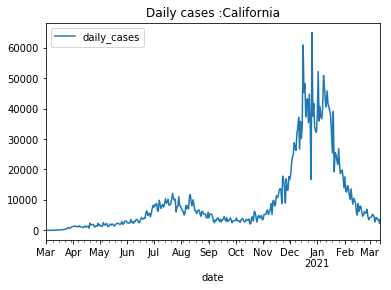

In [26]:
df_clean.plot(title=f"Daily cases :{STATE}")

In [27]:
df_clean.shape[0]

378

In [28]:
train_data = df_clean.iloc[:int(len(df_clean)*0.8)]
test_data = df_clean.iloc[int(len(df_clean)*0.8):]

# train_data = np.expand_dims(train_data, axis=1)
# test_data = np.expand_dims(test_data, axis=1)

train_data.shape, test_data.shape 

((302, 1), (76, 1))

In [29]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

scaler = scaler.fit(train_data)

train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)

In [30]:
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)

In [31]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        #print(i)
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [32]:
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [33]:
X_train.shape , y_train.shape , X_test.shape, y_test.shape

(torch.Size([280, 21, 1]),
 torch.Size([280, 1]),
 torch.Size([54, 21, 1]),
 torch.Size([54, 1]))

In [34]:
X_train = torch.reshape(X_train,(X_train.shape[0],1,-1))
X_test =  torch.reshape(X_test,(X_test.shape[0],1,-1))

In [35]:
X_train.shape , y_train.shape , X_test.shape, y_test.shape

(torch.Size([280, 1, 21]),
 torch.Size([280, 1]),
 torch.Size([54, 1, 21]),
 torch.Size([54, 1]))

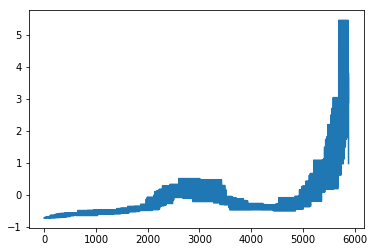

In [36]:
plt.plot(range(len(X_train.flatten())), X_train.flatten())

In [37]:
from torch.utils.data import TensorDataset

# Define dataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

In [38]:
BATCH_SIZE = 7  #keeping it binary so it fits GPU
# #Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=ds_train, 
                                           batch_size=BATCH_SIZE, 
                                            shuffle=True)
#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=ds_test, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

# Training Section

## Define Model

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self,kernel_size=3,dilation=1,in_dim=16,hidden_dim=64,out_dim=128):
        super(ResidualBlock, self).__init__()
        self.pad = (kernel_size - 1) * dilation
        
        #self.casual1 = nn.Conv1d(in_channels=16,out_channels=32,kernel_size=kernel_size,stride=1,padding=self.pad,dilation=dilation)
        #self.casual2 = nn.Conv1d(in_channels=32,out_channels=64,kernel_size=kernel_size,stride=1,padding=self.pad,dilation=dilation)
        
        self.layer_1 = nn.Sequential(nn.utils.weight_norm(nn.Conv1d(in_channels=in_dim,out_channels=hidden_dim,
                                     kernel_size=kernel_size,stride=1,padding=self.pad,dilation=dilation)),
                                     nn.LeakyReLU(0.1),nn.Dropout(p=0.2))
         
        self.layer_2 = nn.Sequential(nn.utils.weight_norm(nn.Conv1d(in_channels=hidden_dim,out_channels=out_dim,
                                    kernel_size=kernel_size,stride=1,padding=self.pad,dilation=dilation)),
                                    nn.LeakyReLU(0.1),nn.Dropout(p=0.2))
        
        self.conv1_1 = nn.Conv1d(in_channels=in_dim,out_channels=out_dim,
                                                        kernel_size=1,stride=1,padding=0,dilation=1)
        
    def forward(self,x):
        
        x_iden = x
        x = self.layer_1(x)
        x = x[:,:,:-self.pad]
        #print(x.shape)
        x = self.layer_2(x) 
        x = x[:,:,:-self.pad]
        #print(x.shape)
        x_iden = self.conv1_1(x_iden)
        #print(x_iden.shape)
        x = x + x_iden
        
        return x         

In [40]:
class TemporalConvNet(nn.Module):
    def __init__(self,num_residual_layers,channel_config,num_classes):
        super(TemporalConvNet, self).__init__()
        self.num_residual_layers = num_residual_layers 
        self.residual_layers = []
        #print(self.num_residual_layers)
        
        for i in range(self.num_residual_layers):
            d = pow(2, i)
            #print(d)
            self.residual_layers.append(ResidualBlock(kernel_size=3,dilation=d,in_dim=channel_config[i][0],hidden_dim=channel_config[i][1],out_dim=channel_config[i][2]).to(device))        
      
        self.fc = nn.Sequential(nn.Linear(21 , 14),nn.ReLU(),nn.Dropout(0.5),
                                nn.Linear(14,7),nn.ReLU(),
                                nn.Dropout(0.5),nn.Linear(7,4))
        
        
        self.out = nn.Linear(4, 1)
        #self.softmax = nn.LogSoftmax(dim=1)
        

        #self.fc = nn.Sequential(nn.Linear(75 ,100),nn.ReLU(),nn.Linear(100,10))
        
    def forward(self,x):
        for layer in self.residual_layers:
            x = layer(x)
        #print("layer :",x.shape)
        x = torch.flatten(x,start_dim=1)
        #print("flatten:",x.shape)        
        x = self.fc(x).to(device)
        
        x = self.out(x).to(device)
        #print(x.shape)
    
        return x

In [41]:
print("Configured device: ", device)

Configured device:  cuda


## Create model

In [42]:
model_Tcn = TemporalConvNet(num_residual_layers=3,channel_config=channel_config,num_classes=1)
model_Tcn = model_Tcn.float()
models = [model_Tcn]

In [43]:
for model in models:
    model = model.to(device)

### Create Optimizer

In [44]:
import torch.optim as optim
#0.01
learning_rate = 1e-4

optimizer = optim.Adam(model.parameters())

criterion = torch.nn.MSELoss().float() #nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Function

In [45]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
   # loss_list = []
    model.train()
    
    for batch, num_cases in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        num_cases = num_cases.to(device) 
#         num_cases = num_cases[:,-1]
#         num_cases =  torch.reshape(num_cases, (num_cases.shape[0], 1))
        #Forward pass
        #print("batch train:",batch.shape)
        outputs = model(batch.float())
#         print("outputs:",outputs.shape)
#         print("num_cases :",num_cases.shape)
#         print("outputs :",outputs)
#         print("num_cases :",num_cases)
        loss = criterion(outputs, num_cases.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #loss_list.append(loss.data)  
         
#         #check accuracy
#         predictions = model(batch.float())
#         _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
#          #keep track of total
#         correct += (predicted == labels).sum().item()  #.item() give the raw number
#         acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
#         epoch_acc = acc
      
    return epoch_loss / len(iterator)  #, epoch_acc, predicted

In [46]:
def test(model,iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
   # loss_list = []
    for batch, num_cases in iterator:
        batch = batch.to(device)
        num_cases = num_cases.to(device)
        #print("batch test:",batch.shape)
        with torch.no_grad():
            y_test_pred = model(batch.float())
            loss = criterion(y_test_pred, num_cases.float())
            epoch_loss += loss
            
    return epoch_loss / len(iterator)  

In [47]:
from IPython.display import clear_output

In [48]:
name = f"Epoch ={N_EPOCHS} LR = {learning_rate} Adam"

In [49]:
best_valid_loss = float('inf')
loss_train = []
loss_test= []
for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    #start_time = time.time()

    for epoch in range(N_EPOCHS):
        #start_time = time.time()
        loss  = train(model, train_iterator, optimizer, criterion) 
        test_loss = test(model, test_iterator, optimizer, criterion)
        print(f'Epoch {epoch} train loss: {loss} test loss: {test_loss}') 
        loss_train.append(loss)
        loss_test.append(test_loss)
        
        # if epoch % 50 == 0:
        #     clear_output(wait=True)
            
        # if test_loss  < best_valid_loss:
        #         best_valid_loss = test_loss
        #         torch.save(model.state_dict(), f'./drive/Shareddrives/BI&A/Prediction_Code/models/TCN/{name}.pt')

Training TemporalConvNet
Epoch 0 train loss: 1.0496093414723873 test loss: 0.693382740020752
Epoch 1 train loss: 1.0488237738609314 test loss: 0.6952444911003113
Epoch 2 train loss: 1.0395529542118311 test loss: 0.6582902669906616
Epoch 3 train loss: 1.0398616336286068 test loss: 0.6845689415931702
Epoch 4 train loss: 1.0396833166480064 test loss: 0.7346843481063843
Epoch 5 train loss: 1.0281466338783503 test loss: 0.6738568544387817
Epoch 6 train loss: 1.0363121662288903 test loss: 0.7285736799240112
Epoch 7 train loss: 1.0275032367557286 test loss: 0.6726664900779724
Epoch 8 train loss: 1.0204307828098536 test loss: 0.6959776878356934
Epoch 9 train loss: 1.011634862050414 test loss: 0.7175480723381042
Epoch 10 train loss: 1.023762321099639 test loss: 0.7489684820175171
Epoch 11 train loss: 1.0138753592967986 test loss: 0.7023027539253235
Epoch 12 train loss: 1.008502697572112 test loss: 0.6623541712760925
Epoch 13 train loss: 1.006483519077301 test loss: 0.6906101703643799
Epoch 14 t

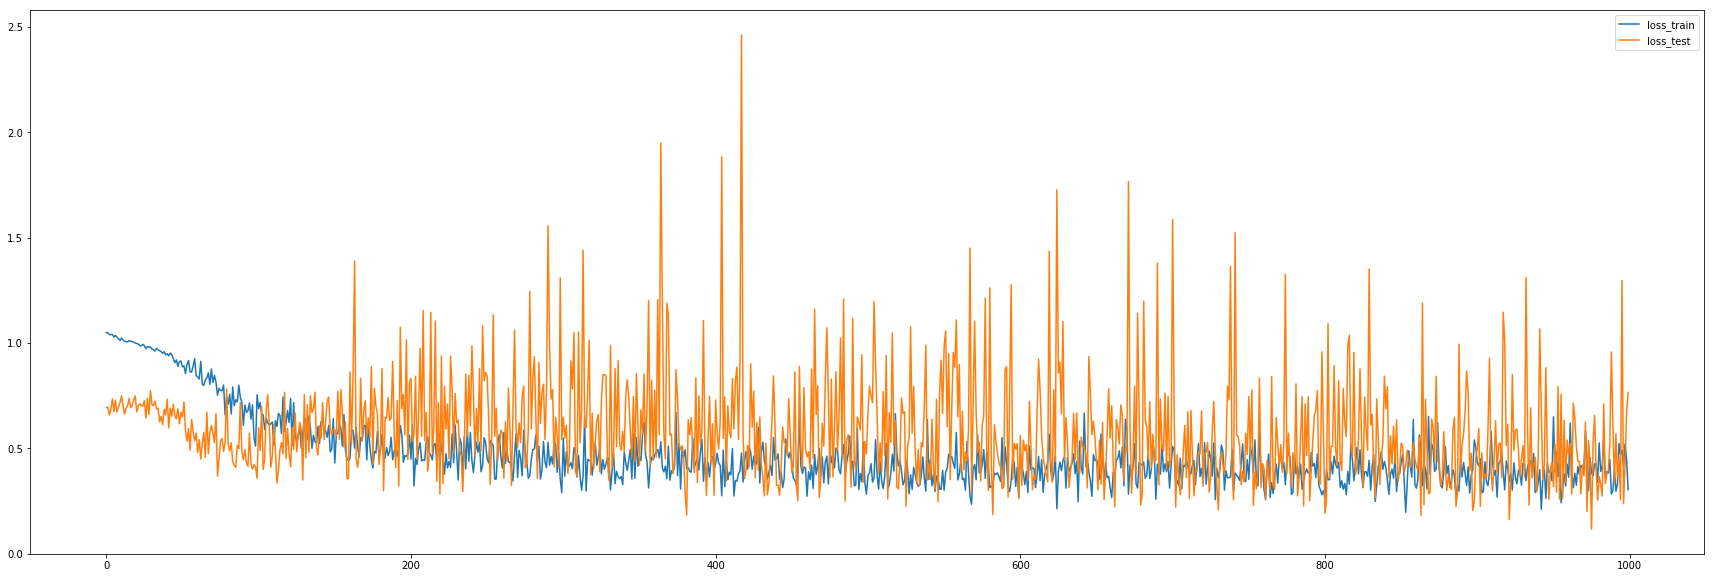

In [50]:
plt.figure(figsize=(30, 10))
plt.plot(loss_train)
plt.plot(loss_test)
plt.legend(['loss_train','loss_test'])

# Predicted daily case

In [51]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  test_losses = []
  for i in range(len(X_test)):
    y_test_pred = model(test_seq.to(device))
    test_loss = criterion(y_test_pred.float(), y_test[i].to(device))
    test_losses.append(test_loss.item())
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, 1, seq_length).float()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [52]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
).flatten()

test_case = scaler.inverse_transform(test_data).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [54]:
predicted_cases

array([27631.69155599, 15267.14533953, 21626.50389234, 11184.45002544,
       27496.14349867, 17617.05348924, 35677.84846641, 17721.26759109,
       15860.58655722, 30962.17150894, 20776.0300994 , 16853.54216319,
        9660.67504029,  6534.47471712, 14008.67865525,  6534.47471712,
       12988.95408042,  8083.97426464, 12062.5350032 ,  8584.75587926,
        6534.47471712, 11591.93083773,  5898.97214821,  5970.37694937,
        3518.47703284,  6534.47471712,  6534.47471712,  6534.47471712,
        6590.88374559,  5179.8526466 ,  8140.08367551, 10489.7195723 ,
        7338.26032656,  5595.31294165,  2531.09384464,  5203.65551863,
        2496.16917328,  5941.4469776 ,  6534.47471712,  2260.81060046,
        5643.2065651 ,  3917.99905096,  5466.81088659,  5051.20474439,
        6534.47471712,  2082.56483464,  2958.88086542,  4494.29515787,
        6534.47471712,  6534.47471712,  6534.47471712,  4937.69706811,
        4313.60901994,  4232.68086905])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:2019: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:249: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


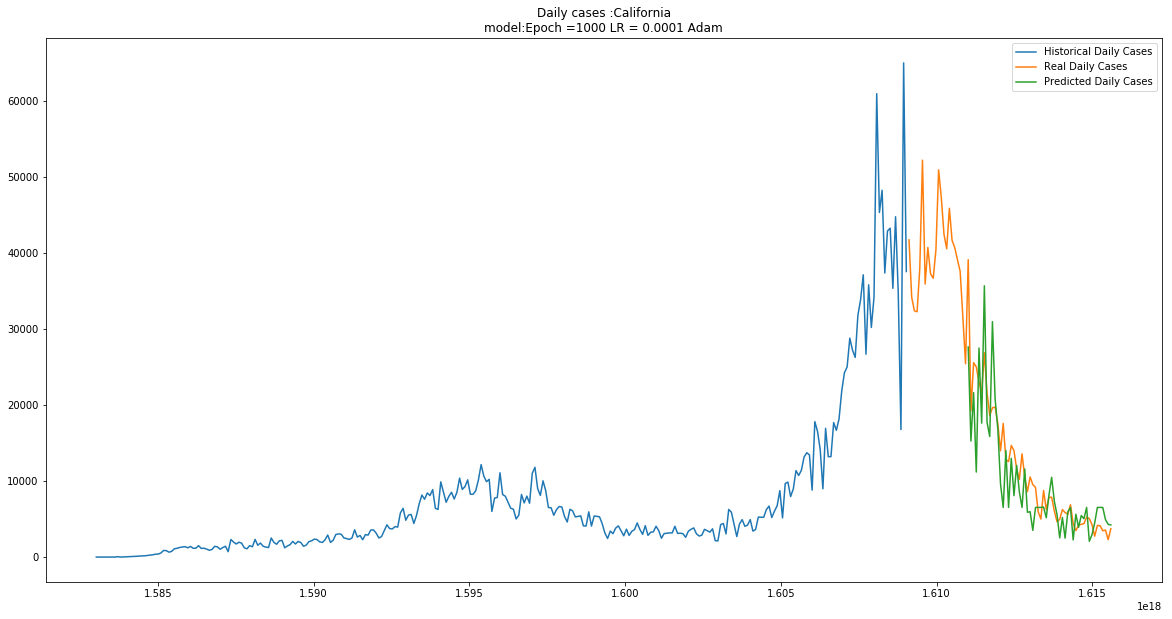

In [53]:
plt.figure(figsize=(20,10))
plt.title(f"Daily cases :{STATE}\nmodel:{name}")
plt.plot(
  df_clean.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  df_clean.index[len(train_data):len(train_data)+len(test_data)], 
  test_case,
  label='Real Daily Cases'
)

# plt.plot(
#   df_clean.index[len(train_data):len(train_data)+len(test_data)], 
#   test_data,
#   label='Scale Daily Cases'
# )

plt.plot(
  df_clean.index[len(train_data)+seq_length+1:len(train_data)+len(test_data)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

# plt.plot(
#   df_clean.index[len(train_data)+seq_length+1:len(train_data)+len(test_data)], 
#   (np.asarray(preds)), 
#   label='Original Predicted Daily Cases'
# )

plt.legend();

In [1]:
predicted_cases

NameError: name 'predicted_cases' is not defined

In [56]:
#np.savetxt('TCN_California.csv', predicted_cases, delimiter=',')

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  test_losses = []
  for i in range(len(X_test)):
    y_test_pred = model(test_seq.to(device))
    test_loss = criterion(y_test_pred.float(), y_test[i].to(device))
    test_losses.append(test_loss.item())
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, 1, seq_length).float()